# Model fitting notebook
---


In [1]:
import matplotlib.pyplot as plt
from matplotlib.transforms import ScaledTranslation
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import logsumexp
from scipy.stats import norm
import scipy.optimize
import random
from src.functions import * 

# Set some defaults
plt.rc("axes.spines", top=False, right=False)
sns.set_theme(context="paper", font_scale=1.2)
sns.set_style("ticks")
plt.rc("axes.spines", top=False, right=False)

%config InlineBackend.figure_format = "retina"

---
## Load behavioral data


In [2]:
# Read in vmr data
df = pd.read_csv("../results/vmr_all.csv")
df.head()

,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,theta_maxradv_outlier,hand_max_dist_outlier,theta_maxradv_mean,hand_max_dist_mean,theta_maxradv_clean,hand_max_dist_clean,motor_sd,extent_err,adaptation_ext,perturbation
0,1,1,01_i,s,72,72,5.646301,90.778669,0.0,0.0,...,False,False,1.076975,88.242944,6.542682,90.954096,1.661801,0.954096,NaN,False
1,1,1,01_i,s,73,73,4.886301,88.328669,0.0,0.0,...,False,False,1.076975,88.242944,1.027300,88.463720,1.661801,-1.536280,0.851176,True
2,1,1,01_i,s,74,74,5.006301,91.668669,0.0,0.0,...,False,False,1.076975,88.242944,4.205676,91.805272,1.661801,1.805272,NaN,False
3,1,1,01_i,s,75,75,2.246301,90.208669,0.0,0.0,...,False,False,1.076975,88.242944,3.467717,90.236633,1.661801,0.236633,-4.039820,True
4,1,1,01_i,s,76,76,1.716301,87.748669,0.0,0.0,...,False,False,1.076975,88.242944,3.777826,87.765452,1.661801,-2.234548,NaN,False


---
## Helper functions

In [3]:
def plot_individual(df, ege, ige, adaptation, color="k", title=None):
    fig, axs = plt.subplots(1, 2, figsize=(4.5, 3))
    sns.regplot(data=df, x=ege, x_jitter=0.1, y=adaptation, 
               scatter_kws={"alpha":0.15, "color":"gray"},  line_kws={"color":color}, ax=axs[0])
    axs[0].set(xlabel="EGE ($\degree$)", ylabel="Adaptation ($\degree$)", 
               xlim=[-6.5, 6.5], xticks=np.arange(-4, 4.01, 2), ylim=[-10, 10], 
               yticks=np.arange(-10, 10.01, 2))
    axs[0].axhline(color="k", linewidth=0.5)

    sns.regplot(data=df, x=ige, y=adaptation, line_kws={"color":color}, 
                scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
    axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2), xlim=[-6.5, 6.5], 
               xticks=np.arange(-4, 4.01, 2), xlabel="IGE ($\degree$)", 
               ylabel="Adaptation ($\degree$)")
    axs[1].axhline(color="k", linewidth=0.5)
    sns.despine()
    fig.suptitle(title, y=0.90)
    plt.tight_layout()
    
    return fig


def plot_individual_ege(df, ege, ige, adaptation, color="k", ax=None, title=None):
    sns.regplot(data=df, x=ege, x_jitter=0.1, y=adaptation, 
               scatter_kws={"alpha":0.4, "color":"gray"},  line_kws={"color":color}, ax=ax)
    ax.set(xlabel="Rotation ($^\circ$)", ylabel="Adaptation  ($\degree$)", 
               xlim=[-6.5, 6.5], xticks=np.arange(-4, 4.01, 2), ylim=[-10, 10], 
               yticks=np.arange(-10, 10.01, 2))
    ax.axhline(color="k", linewidth=0.5)

def plot_individual_ige(df, ege, ige, adaptation, color="k", ax=None, title=None):
    sns.regplot(data=df, x=ige, y=adaptation, line_kws={"color":color}, 
                scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
    axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2), xlim=[-6.5, 6.5], 
               xticks=np.arange(-4, 4.01, 2), xlabel="Motor noise ($\degree$)", 
               ylabel="Adaptation ($\degree$)")
    axs[1].axhline(color="k", linewidth=0.5)
    
    sns.despine()
    fig.suptitle(title)
    plt.tight_layout()
    
    return fig

---
## Fit data using Maximum Likelihoood Estimation (MLE)

In [4]:
%%time 
subj_num = []
model = []
theta = []
loglik = []
bic = []
delta_bic = []
n_inits = 5  # num of random intializations to try

# Fit models to data
for i in range(len(np.unique(df["SN"]))):
    subj = df.loc[df["SN"] == i + 1, :]

    # Get rid of all nan trials
    subj = subj.loc[~np.isnan(subj["theta_maxradv_clean"]), :]
    
    # Extract important variables
    motor_sd = subj["motor_sd"].iloc[0]
    x_hand = subj["theta_maxradv_clean"].values
    rotation = subj["rotation"].values
    vis_fb = subj["fbi"].values

    # Define cost functions
    nll_pea = lambda x: negloglik(model="pea", sigma_int=x[0], B=x[1], bias=x[2], 
                                       sigma_motor=motor_sd, num_trials=len(subj), 
                                       vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)
    nll_premo = lambda x: negloglik(model="premo", B=x[0], sigma_pred=x[1], 
                                         sigma_v=x[2], sigma_p=x[3], eta_p=x[4], bias=x[5], 
                                         sigma_motor=motor_sd, num_trials=len(subj), 
                                         vis_fb=vis_fb, rotation=rotation, 
                                         x_hand=x_hand)
    nll_piece = lambda x: negloglik(model="piece", sigma_pert=x[0], sigma_comb=x[1], 
                                         bias = x[2], sigma_motor=motor_sd, num_trials=len(subj), 
                                         vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)
    nll_piece_variant = lambda x: negloglik(model="piece_variant", sigma_pert=x[0], sigma_comb=x[1], 
                                         bias = x[2], sigma_motor=motor_sd, num_trials=len(subj), 
                                         vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)
    nll_rem = lambda x: negloglik(model="rem", sigma_comb=x[0], s=x[1], c=x[2], bias=x[3],
                                       sigma_motor=motor_sd, num_trials=len(subj), 
                                       vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)
    
    # Fit models: use different random initializations
    for k in range(n_inits):
        # PEA model params: sigma_comb, B, bias
        bounds = ((0.01, 10), (0, 1), (-5, 5))
        tmp_pea = scipy.optimize.minimize(
            fun=nll_pea, 
            bounds=bounds,
            x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
                         np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
                         np.random.uniform(low=bounds[2][0], high=bounds[2][1])])
        )
            
        # PReMo model params: B, sigma_v, sigma_p, sigma_pred, eta_p, bias
        bounds = ((0, 1), (0.01, 10), (0.01, 10), (0.01, 10), (0, 1), (-5, 5))
        tmp_premo = scipy.optimize.minimize(
            fun=nll_premo,  
            bounds=bounds,
            x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
                         np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
                         np.random.uniform(low=bounds[2][0], high=bounds[2][1]),
                         np.random.uniform(low=bounds[3][0], high=bounds[3][1]),
                         np.random.uniform(low=bounds[4][0], high=bounds[4][1]),
                         np.random.uniform(low=bounds[5][0], high=bounds[5][1])])
        )
    
        # REM model params: sigma_comb, s, c, bias
        bounds = ((0.01, 10), (0, 10), (0, 10), (-5, 5))
        tmp_rem = scipy.optimize.minimize(
            fun=nll_rem, 
            bounds=bounds,
            x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
                         np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
                         np.random.uniform(low=bounds[2][0], high=bounds[2][1]),
                         np.random.uniform(low=bounds[3][0], high=bounds[3][1])])
        )
    
        # PIECE model params: sigma_pert, sigma_comb, bias
        bounds = ((0.01, 30), (0.2, 10), (-5, 5))  # sigma_comb: 10 x's < motor var
        tmp_piece = scipy.optimize.minimize(
            fun=nll_piece, 
            bounds=bounds,
            x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
                         np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
                         np.random.uniform(low=bounds[2][0], high=bounds[2][1])])
        )

        # # PIECE VARIANT model params: sigma_pert, sigma_comb, bias
        # bounds = ((0.01, 30), (0.2, 10), (-5, 5))  # sigma_comb: 10 x's < motor var
        # tmp_piece_variant = scipy.optimize.minimize(
        #     fun=nll_piece_variant, 
        #     bounds=bounds,
        #     x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
        #                  np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
        #                  np.random.uniform(low=bounds[2][0], high=bounds[2][1])])
        # )

        # Compare negative log-likelihoods; assign best results
        if k == 0:
            pea_results = tmp_pea
            premo_results = tmp_premo
            rem_results = tmp_rem
            piece_results = tmp_piece
            # piece_variant_results = tmp_piece_variant
        elif k != 0: 
            if tmp_pea.fun < pea_results.fun:
                pea_results = tmp_pea
            if tmp_premo.fun < premo_results.fun:
                premo_results = tmp_premo
            if tmp_rem.fun < rem_results.fun:
                rem_results = tmp_rem
            if tmp_piece.fun < piece_results.fun:
                piece_results = tmp_piece
            # if tmp_piece_variant.fun < piece_variant_results.fun:
                # piece_varaint_results = tmp_piece_variant
        
        if k == n_inits - 1:    
            print(f"{i: } {pea_results.message}")
            print(f"{i: } {premo_results.message}")
            print(f"{i: } {rem_results.message}") 
            print(f"{i: } {piece_results.message}")
            # print(f"{i: } {piece_variant_results.message}")

    # Fill in variables for "fits" data frame
    subj_num.extend([i + 1, i + 1, i + 1, i + 1])
    model.extend(["pea", "premo", "rem", "piece"])
    theta.extend([pea_results.x, premo_results.x, rem_results.x, 
                  piece_results.x])
    loglik.extend([pea_results.fun * -1, 
                   premo_results.fun * -1, rem_results.fun * -1, piece_results.fun * -1])
    bic.extend([calc_bic(pea_results.fun * -1, len(pea_results.x), len(subj)),
                calc_bic(premo_results.fun * -1, len(premo_results.x), len(subj)),
                calc_bic(rem_results.fun * -1, len(rem_results.x), len(subj)),
                calc_bic(piece_results.fun * -1, len(piece_results.x), len(subj))])
    bic_ref = calc_bic(premo_results.fun * -1, len(premo_results.x), len(subj))  # premo serves as benchmark
    delta_bic.extend([bic[-4] - bic_ref, bic[-3] - bic_ref, bic[-2] - bic_ref, bic[-1] - bic_ref])

fits = pd.DataFrame({
    "subj_num":subj_num, 
    "model":model, 
    "theta":theta, 
    "loglik":loglik, 
    "bic":bic,
    "delta_bic":delta_bic
})
    

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 0 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
 1 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 1 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 1 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 1 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


/Users/hyosubkim/Documents/GitHub/Projects/ige-ege/src/functions.py:164: RuntimeWarning: invalid value encountered in double_scalars
  p_rel = s * (np.exp(-(x_v)**2 / (2 * sigma_comb**2))) / (np.exp(-(x_v)**2 / (2 * sigma_comb**2)) + c)


 2 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 2 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 2 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 2 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
 3 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 3 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 3 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 3 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 4 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 4 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 4 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 4 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 5 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
 5 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 5 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 5 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
 6 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
 6 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 6 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 6 CONVERGENCE: REL_REDUCTI

In [5]:
fits.groupby("model")["bic"].describe().reset_index()

,model,count,mean,std,min,25%,50%,75%,max
0,pea,16.0,5459.347510,502.619455,4631.992740,5190.614844,5390.260775,5676.686976,6733.813961
1,piece,16.0,5247.460879,481.784686,4394.464357,5015.428466,5211.242711,5420.708362,6431.773556
2,premo,16.0,5585.865914,485.435774,4919.383426,5243.388122,5491.216140,5853.764636,6805.381563
3,rem,16.0,5468.752130,511.606222,4638.621662,5195.510295,5396.335547,5684.008185,6791.160170


---
## Read and/or write parameters

In [19]:
# Save MLEs? 
write_data = False

# Read-in saved parameters?
read_data = True

# Helper function
def converter(input_str):
    return np.fromstring(input_str[1:-1], sep=' ')
    
# Write data to csv; look into preserving numpy dtype for "theta" column
if write_data:
    fits.to_csv("../results/params_mle.csv", index=False)

# Need a function to convert string back to numpy array
if read_data:
    fits = pd.read_csv("../results/params_mle.csv", converters={"theta":converter})
    # fits = pd.read_csv("../results/params_mle_piecevariant.csv", converters={"theta":converter})
fits.head()

,subj_num,model,theta,loglik,bic,delta_bic,piece_v_pea,piece_v_premo,piece_v_rem
0,1,pea,"[10.0, 0.36381731, 1.30064756]",-2636.097934,5293.515686,-214.360930,-247.260544,-461.621475,-254.471864
1,1,premo,"[0.924575, 3.15558839, 0.99138054, 5.2033649, ...",-2732.618490,5507.876617,0.000000,-247.260544,-461.621475,-254.471864
2,1,rem,"[10.0, 0.46212942, 0.34019152, 1.30076367]",-2636.150291,5300.727007,-207.149610,-247.260544,-461.621475,-254.471864
3,1,piece,"[5.98095171, 0.2, 1.00916519]",-2512.467662,5046.255142,-461.621475,-247.260544,-461.621475,-254.471864
4,2,pea,"[3.81228018, 0.48715132, 0.89635988]",-2824.452855,5670.205792,-178.326603,-238.299972,-416.626576,-245.673406


/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_52002/1779479410.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xlabel=None, xticklabels=["$\sigma_r$", "$\sigma_{combined}$"], ylabel="MLE")


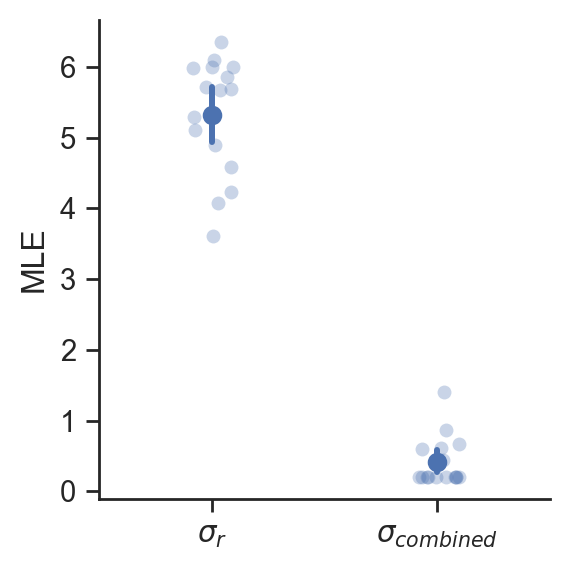

In [20]:
# Plot MLEs for PIECE params
sigma_u = np.zeros(16)
sigma_comb = np.zeros(16)
for i in range(16):
    for j in range(2):
        if j == 0:
            sigma_u[i] = fits.loc[fits["model"] == "piece", "theta"].iloc[i][j]
        elif j == 1:
            sigma_comb[i] = fits.loc[fits["model"] == "piece", "theta"].iloc[i][j]

# idx_outlier = sigma_comb.argmax() # Crazy value of 25
# sigma_u = np.delete(sigma_u, idx_outlier)
# sigma_comb = np.delete(sigma_comb, idx_outlier)
# sigma_comb

plt.rc("axes.spines", top=False, right=False)

# Plot MLEs of PIECE params
param_vals = np.hstack((sigma_u, sigma_comb))
param_labels = []
[param_labels.append("sigma_u") for x in range(len(sigma_u))] 
[param_labels.append("sigma_comb") for x in range(len(sigma_comb))]
piece_mle = pd.DataFrame({"param_labels":param_labels, "param_vals":param_vals})
piece_mle.head()

fig, ax = plt.subplots(figsize=(3, 3))
sns.pointplot(data=piece_mle, x="param_labels", y="param_vals", ax=ax, c="b", linestyle="none")
sns.stripplot(data=piece_mle, x="param_labels", y="param_vals", alpha=0.3, ax=ax, c="b")
ax.set(xlabel=None, xticklabels=["$\sigma_r$", "$\sigma_{combined}$"], ylabel="MLE")
plt.tight_layout()
plt.show()
fig.savefig("images/param_mles.png", dpi=300)

In [21]:
# Compute BIC deltas between models
idx_pea = fits["model"] == "pea"
idx_piece = fits["model"] == "piece"
idx_rem = fits["model"] == "rem"
idx_premo = fits["model"] == "premo"

# fits["piece_v_pea"] = np.zeros(len(fits))
diff_pea = fits.loc[idx_piece, "bic"].values - fits.loc[idx_pea, "bic"].values
diff_premo = fits.loc[idx_piece, "bic"].values - fits.loc[idx_premo, "bic"].values
diff_rem = fits.loc[idx_piece, "bic"].values - fits.loc[idx_rem, "bic"].values

fits["piece_v_pea"] = np.repeat(diff_pea, 4)  # repeating to fill appropriate rows
fits["piece_v_premo"] = np.repeat(diff_premo, 4)
fits["piece_v_rem"] = np.repeat(diff_rem, 4)
fits

,subj_num,model,theta,loglik,bic,delta_bic,piece_v_pea,piece_v_premo,piece_v_rem
0,1,pea,"[10.0, 0.36381731, 1.30064756]",-2636.097934,5293.515686,-214.360930,-247.260544,-461.621475,-254.471864
1,1,premo,"[0.924575, 3.15558839, 0.99138054, 5.2033649, ...",-2732.618490,5507.876617,0.000000,-247.260544,-461.621475,-254.471864
2,1,rem,"[10.0, 0.46212942, 0.34019152, 1.30076367]",-2636.150291,5300.727007,-207.149610,-247.260544,-461.621475,-254.471864
3,1,piece,"[5.98095171, 0.2, 1.00916519]",-2512.467662,5046.255142,-461.621475,-247.260544,-461.621475,-254.471864
4,2,pea,"[3.81228018, 0.48715132, 0.89635988]",-2824.452855,5670.205792,-178.326603,-238.299972,-416.626576,-245.673406
...,...,...,...,...,...,...,...,...,...
59,15,piece,"[5.68016988, 0.2, -0.01090963]",-2838.582537,5698.497162,-240.533567,-158.827231,-240.533567,-165.637726
60,16,pea,"[4.40720088, 0.22310439, 0.17393832]",-2684.924939,5391.162310,-52.932937,-87.044411,-139.977348,-92.255408
61,16,premo,"[0.13633946, 5.08211851, 7.14714084, 7.2766334...",-2700.735192,5444.095248,0.000000,-87.044411,-139.977348,-92.255408
62,16,rem,"[1.77207562, 0.179744689, 0.00068847344, 0.169...",-2683.978365,5396.373307,-47.721941,-87.044411,-139.977348,-92.255408


In [22]:
mask = fits["model"] == "piece"
fits.loc[mask, "theta"]


3            [5.98095171, 0.2, 1.00916519]
7            [6.00387584, 0.2, 0.72010777]
11     [3.60754452, 1.40483735, 1.8433497]
15           [4.58392405, 0.2, 0.18617462]
19    [4.90196935, 0.43758069, 0.50745761]
23    [6.00042728, 0.67149065, 0.41334299]
27    [5.86208061, 0.61386754, 0.49522226]
31           [5.28690468, 0.2, 1.42758737]
35           [5.71022855, 0.2, 1.78110779]
39           [5.68743768, 0.2, 0.70773263]
43           [6.10251047, 0.2, 1.34503363]
47    [5.10954709, 0.60139138, 0.33743311]
51           [4.23275669, 0.2, 1.14332879]
55          [6.35628989, 0.2, -0.66487891]
59          [5.68016988, 0.2, -0.01090963]
63    [4.07567647, 0.87061259, 0.14419813]
Name: theta, dtype: object

/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_52002/2170764657.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set(ylabel=r"$\Delta$BIC", xticklabels=["PReMo", "PIECE", "PEA", "REM"],


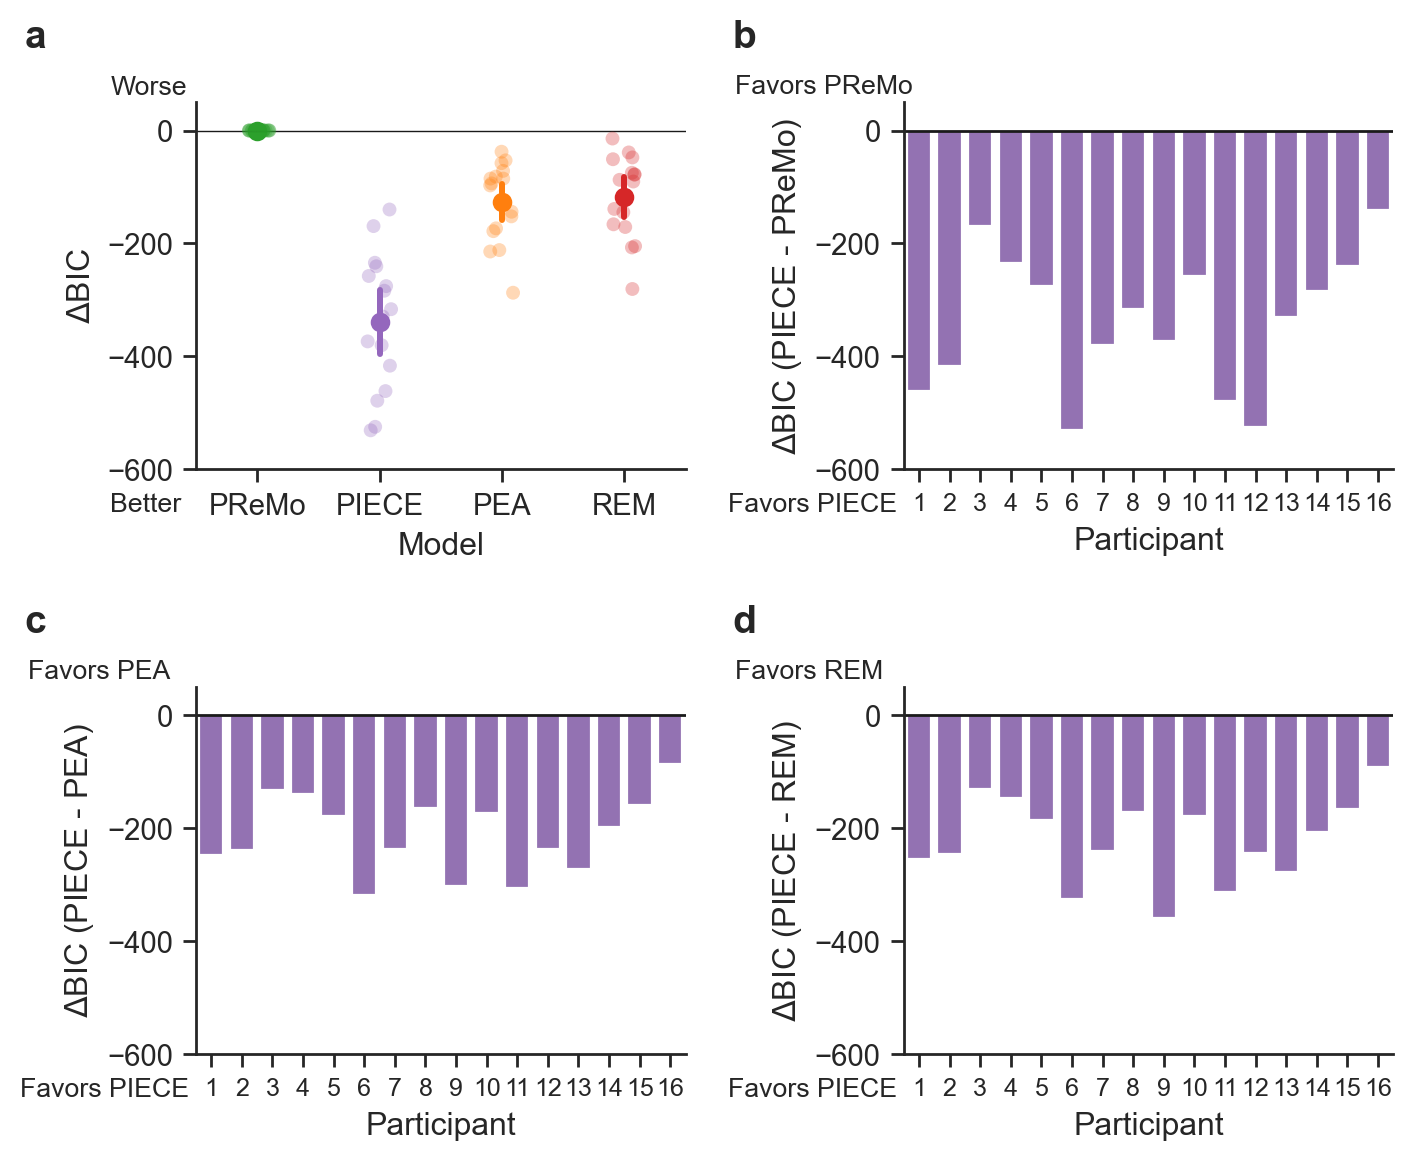

In [42]:
# Assign colors to models
colors = {"premo":"tab:green", "piece":"tab:purple",
          "pea":"tab:orange", "rem":"tab:red"}

# Plot BIC comparisons
fig_bic, axs = plt.subplots(2, 2,figsize=(7.25, 6))
sns.despine()
sns.stripplot(
    data=fits, x="model", y="delta_bic", dodge=False, alpha=0.3, hue="model", 
    legend=False, order=["premo", "piece", "pea", "rem"] , palette=colors,
        ax=axs[0, 0]
)
sns.pointplot(
    data=fits, x="model", y="delta_bic", hue="model", dodge=0.0,
    order=["premo", "piece", "pea", "rem"], **{"linestyle":"none"},
    legend=False, ax=axs[0, 0], palette=colors
)
axs[0, 0].axhline(y=0, color="k", linewidth=0.5)
axs[0, 0].set(ylabel=r"$\Delta$BIC", xticklabels=["PReMo", "PIECE", "PEA", "REM"], 
              xlabel="Model", ylim=(-600, 50))
axs[0, 0].text(-1.2, 65, "Worse", fontsize="small")
axs[0, 0].text(-1.2, -675, "Better", fontsize="small")
axs[0, 0].text(-0.35, 1.15, "a", transform=axs[0, 0].transAxes, 
               fontsize=14, weight="bold")

# PIECE vs PReMo
sns.barplot(
    data=fits, x="subj_num", y="piece_v_premo", errorbar=None, color="tab:purple", 
    ax=axs[0, 1]
)
axs[0, 1].axhline(c="k", linewidth=1)
axs[0, 1].set(xlabel="Participant", ylabel=r"$\Delta$BIC (PIECE - PReMo)", ylim=(-600, 50))
axs[0, 1].tick_params(axis="x", labelsize=9)
axs[0, 1].text(-6, 66, "Favors PReMo", fontsize="small")
axs[0, 1].text(-6.25, -675, "Favors PIECE", fontsize="small")
axs[0, 1].text(-0.35, 1.15, "b", transform=axs[0, 1].transAxes, 
               fontsize=14, weight="bold")

# PIECE vs PEA
sns.barplot(
    data=fits, x="subj_num", y="piece_v_pea", errorbar=None, color="tab:purple", 
    ax=axs[1, 0]
)
axs[1, 0].axhline(c="k", linewidth=1)
axs[1, 0].set(xlabel="Participant", ylabel=r"$\Delta$BIC (PIECE - PEA)", ylim=(-600, 50))
axs[1, 0].tick_params(axis="x", labelsize=9)
axs[1, 0].text(-6, 66, "Favors PEA", fontsize="small")
axs[1, 0].text(-6.25, -675, "Favors PIECE", fontsize="small")
axs[1, 0].text(-0.35, 1.15, "c", transform=axs[1, 0].transAxes, 
               fontsize=14, weight="bold")

# PIECE vs REM
sns.barplot(
    data=fits, x="subj_num", y="piece_v_rem", errorbar=None, color="tab:purple", 
    ax=axs[1, 1]
)
axs[1, 1].axhline(c="k", linewidth=1)
axs[1, 1].set(xlabel="Participant", ylabel=r"$\Delta$BIC (PIECE - REM)", ylim=(-600, 50))
axs[1, 1].tick_params(axis="x", labelsize=9)
axs[1, 1].text(-6, 66, "Favors REM", fontsize="small")
axs[1, 1].text(-6.25, -675, "Favors PIECE", fontsize="small")
axs[1, 1].text(-0.35, 1.15, "d", transform=axs[1, 1].transAxes, 
               fontsize=14, weight="bold")
plt.tight_layout()


In [ ]:
# fig_bic.savefig("images/bic.pdf", dpi=300)

---
# Plot Models using MLEs ($\hat{\Theta}_{\text{MLE}}$) 

In [30]:
# Choose a sample subject
sid = 1
sample_subj = df.loc[df["SN"] == sid, :].reset_index(drop=True)
sigma_motor = sample_subj.loc[1, "motor_sd"]

# Pull out best-fit params for chosen subject:
params_idx = fits["subj_num"] == sid 
params = fits.loc[params_idx, ["theta", "model"]].iloc[0:5, :].reset_index(drop=True)

# Pull out MLEs for each model
pea_mle = params.loc[params["model"] == "pea", "theta"].values[0]
premo_mle = params.loc[params["model"] == "premo", "theta"].values[0]
piece_mle = params.loc[params["model"] == "piece", "theta"].values[0]
rem_mle = params.loc[params["model"] == "rem", "theta"].values[0]

# Find perturbation trials
pert_indices = np.flatnonzero(sample_subj["perturbation"])

# Simulate with best-fit parameters
# PIECE model
_, xhat_piece = piece(
    piece_mle[0], 
    piece_mle[1], 
    piece_mle[2],
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_piece = xhat_piece[pert_indices + 1] - xhat_piece[pert_indices - 1]

# PEA model
_, xhat_pea = pea(
    pea_mle[0], 
    pea_mle[1],
    pea_mle[2],
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_pea = xhat_pea[pert_indices + 1] - xhat_pea[pert_indices - 1]

# PReMo 
_, xhat_premo = premo(
    premo_mle[0],
    premo_mle[1],
    premo_mle[2], 
    premo_mle[3],
    premo_mle[4],
    premo_mle[5],
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_premo = xhat_premo[pert_indices + 1] - xhat_premo[pert_indices - 1]

# REM
_, xhat_rem = rem(
    rem_mle[0],
    rem_mle[1], 
    rem_mle[2],
    rem_mle[3],
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_rem = xhat_rem[pert_indices + 1] - xhat_rem[pert_indices - 1]

# Create data frame with all perturbation trials
df1 = pd.DataFrame({
    "rotation":sample_subj.loc[pert_indices, "rotation"],
    "xhat_piece":xhat_piece[pert_indices],
    "adapt_piece":adapt_piece,
    "xhat_pea":xhat_pea[pert_indices],
    "adapt_pea":adapt_pea,
    "xhat_premo":xhat_premo[pert_indices],
    "adapt_premo":adapt_premo,
    "xhat_rem":xhat_rem[pert_indices], 
    "adapt_rem":adapt_rem
})

# Trim data frame to adaptation only trials
sample_subj = sample_subj.loc[pert_indices, :]


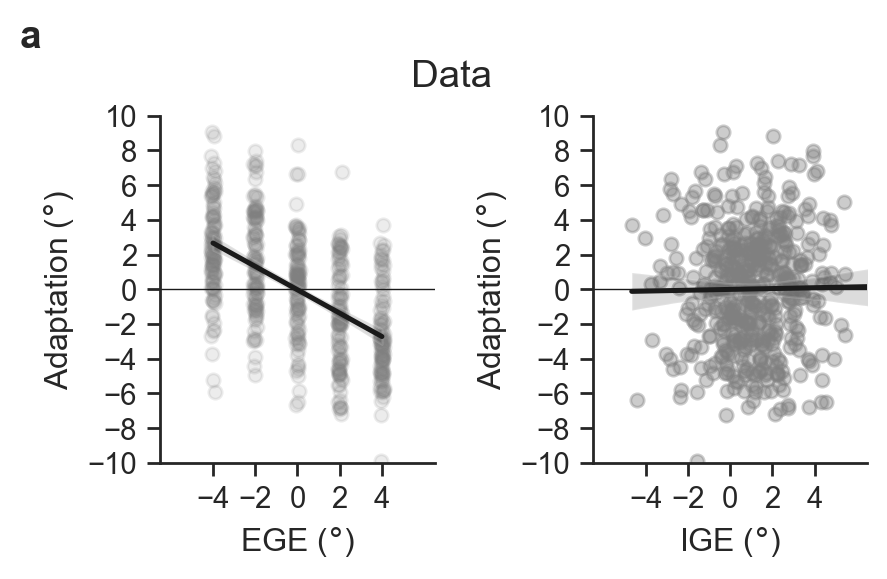

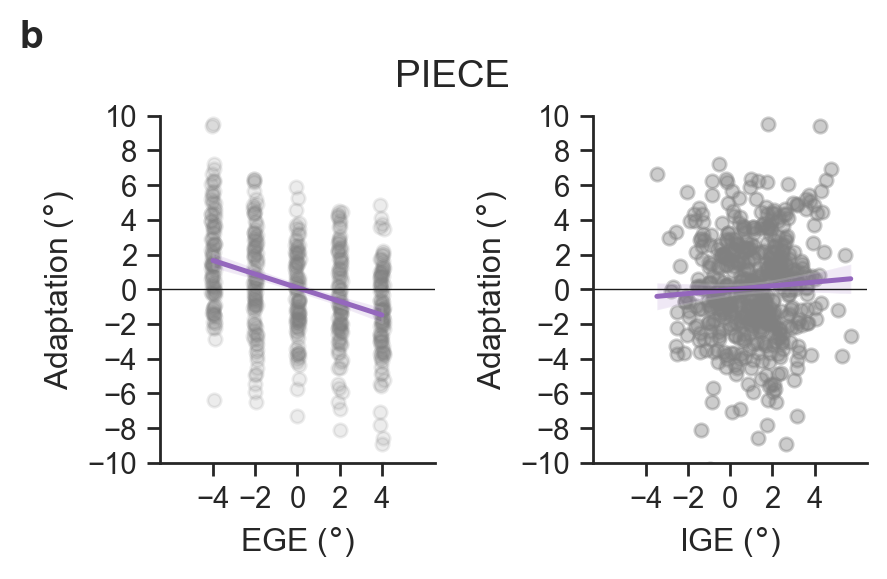

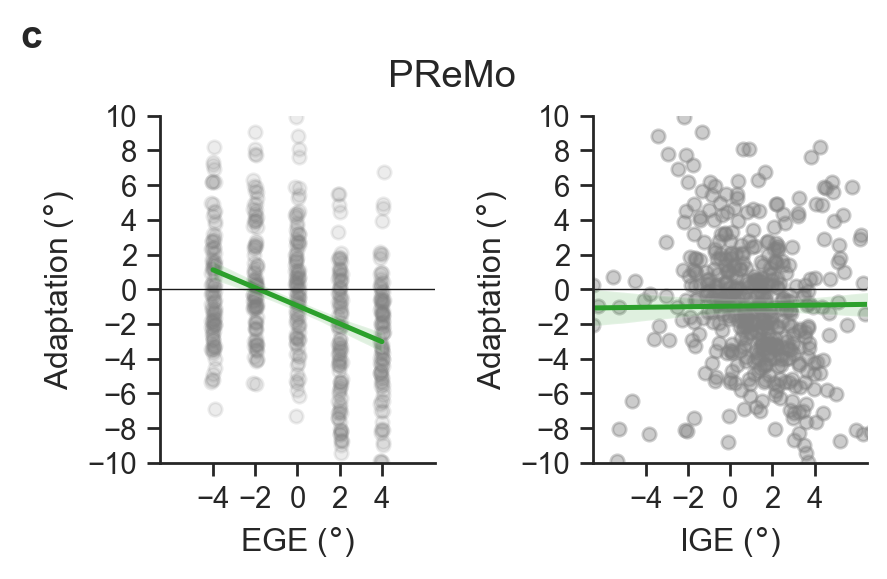

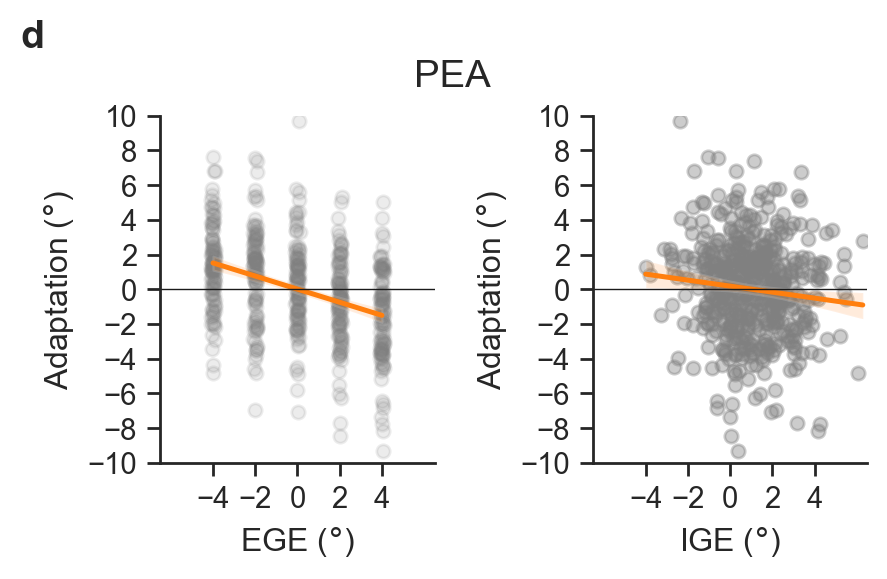

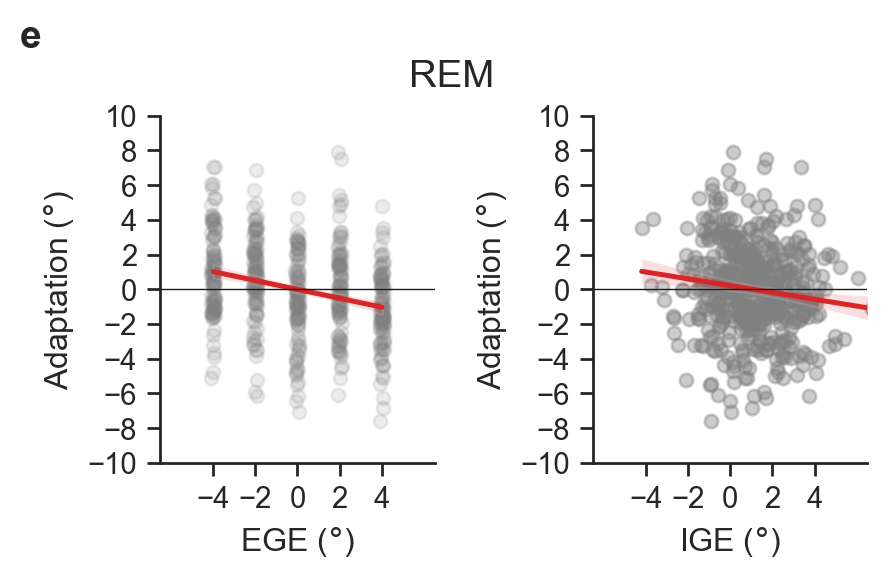

In [31]:
# Assign colors to models
premo_color = "tab:green"
piece_color = "tab:purple"
pea_color = "tab:orange"
rem_color = "tab:red"

# Get rid of outliers 
sample_subj = sample_subj.dropna(subset=["adaptation", "theta_maxradv_clean"])

# Plot best-fits
fig1 = plot_individual(sample_subj, "rotation", "theta_maxradv_clean", "adaptation", title="Data")
plt.gcf().text(0.02, 0.92, "a", fontsize=14, weight="bold")
slope_ege_data, _, _, _, _ = stats.linregress(sample_subj["rotation"], sample_subj["adaptation"])
slope_ige_data, _, _, _, _ = stats.linregress(sample_subj["theta_maxradv_clean"], sample_subj["adaptation"])

fig2 = plot_individual(df1, "rotation", "xhat_piece", "adapt_piece", piece_color, r"PIECE")
plt.gcf().text(0.02, 0.92, "b", fontsize=14, weight="bold")
slope_ege_piece, _, _, _, _ = stats.linregress(df1["rotation"], df1["adapt_piece"])
slope_ige_piece, _, _, _, _ = stats.linregress(df1["xhat_piece"], df1["adapt_piece"])

fig3 = plot_individual(df1, "rotation", "xhat_premo", "adapt_premo", premo_color, r"PReMo")
plt.gcf().text(0.02, 0.92, "c", fontsize=14, weight="bold")
slope_ege_premo, _, _, _, _ = stats.linregress(df1["rotation"], df1["adapt_premo"])
slope_ige_premo, _, _, _, _ = stats.linregress(df1["xhat_premo"], df1["adapt_premo"])

fig4 = plot_individual(df1, "rotation", "xhat_pea", "adapt_pea", pea_color, r"PEA")
plt.gcf().text(0.02, 0.92, "d", fontsize=14, weight="bold")
slope_ege_pea, _, _, _, _ = stats.linregress(df1["rotation"], df1["adapt_pea"])
slope_ige_pea, _, _, _, _ = stats.linregress(df1["xhat_pea"], df1["adapt_pea"])

fig5 = plot_individual(df1, "rotation", "xhat_rem", "adapt_rem", rem_color, r"REM")
plt.gcf().text(0.02, 0.92, "e", fontsize=14, weight="bold")
slope_ege_rem, _, _, _, _ = stats.linregress(df1["rotation"], df1["adapt_rem"])
slope_ige_rem, _, _, _, _ = stats.linregress(df1["xhat_piece"], df1["adapt_rem"])
plt.show()

In [29]:
print(f"slope ege data: {slope_ege_data:.2f}")
print(f"slope ige data: {slope_ige_data:.2f}")
print(f"slope ege piece: {slope_ege_piece:.2f}")
print(f"slope ige piece: {slope_ige_piece:.2f}")
print(f"slope ege premo: {slope_ege_premo:.2f}")
print(f"slope ige premo: {slope_ige_premo:.2f}")
print(f"slope ege pea: {slope_ege_pea:.2f}")
print(f"slope ige pea: {slope_ige_pea:.2f}")
print(f"slope ege rem: {slope_ege_rem:.2f}")
print(f"slope ige rem: {slope_ige_rem:.2f}")

slope ege data: -0.67
slope ige data: 0.02
slope ege piece: -0.46
slope ige piece: 0.18
slope ege premo: -0.67
slope ige premo: 0.06
slope ege pea: -0.39
slope ige pea: -0.04
slope ege rem: -0.36
slope ige rem: 0.13


In [ ]:
# fig1.savefig("images/s13-data.pdf", dpi=300)
# fig2.savefig("images/s13-postpred-piece.pdf", dpi=300)
# fig3.savefig("images/s13-postpred-premo.pdf", dpi=300)
# fig4.savefig("images/s13-postpred-pea.pdf", dpi=300)
# fig5.savefig("images/s13-postpred-rem.pdf", dpi=300)